# JuSpyce API test: cross validation

In [2]:
import sys
import os
from glob import glob
import pathlib
import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.image import load_img

# current path
wd = pathlib.Path().resolve().parent
print(wd)

# import juspyce
sys.path.append(os.path.dirname(os.path.join(wd, "juspyce")))
from juspyce.api import JuSpyce
from juspyce.stats import *
from juspyce.utils import *
from juspyce.nulls import * 

/Users/llotter/projects/juspyce


/Users/llotter/opt/anaconda3/envs/juspyce/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/llotter/opt/anaconda3/envs/juspyce/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load JuSpyce data from test_juspyce.fit.ipynb

In [3]:
juspyce_vol = JuSpyce.from_pickle(os.path.join(wd, "testing", "test_juspyce_vol.pkl.gz"))

INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/juspyce/testing/test_juspyce_vol.pkl.gz.


## Cross validation: Within-brain

We want to have within-brain distance-dependent CV (Hansen and colleagues) and across-subjects k-fold cross validation to cover the two main use cases of JuSpyce. We start with the distance-dependent within-brain method

In [18]:
def distance_cross_val(X, y, dist_mat, train_pct=0.75, adj_r2=True, replace_negative=True):

    full_r2 = r2(x=X, y=y, adj_r2=adj_r2)
    
    train_metric = []
    test_metric = []

    for i in range(len(y)):
        
        distances = dist_mat[i, :]  # for every node
        idx = np.argsort(distances)

        train_idx = idx[:int(np.floor(train_pct * len(dist_mat)))]
        test_idx = idx[int(np.floor(train_pct * len(dist_mat))):]

        betas_train, r2_train, intercept_train = beta(x=X[train_idx, :], y=y[train_idx], intercept=True, r2=True, adj_r2=adj_r2)
        train_metric.append(r2_train)
        
        yhat_test = np.dot(np.c_[X[test_idx, :], np.ones(len(test_idx))], np.r_[betas_train, intercept_train])
        ss_res_test = np.sum((y[test_idx] - yhat_test) **2)
        ss_tot_test = np.sum((y[test_idx] - np.mean(y[test_idx])) **2)
        r2_test = 1 - ss_res_test / ss_tot_test
        if adj_r2:
            r2_test =  1 - (1-r2_test) * (len(test_idx)-1) / (len(test_idx)-X.shape[1]-1)
        test_metric.append(r2_test)
        
    train_metric = np.array(train_metric)
    test_metric = np.array(test_metric)
    if replace_negative:
        train_metric[train_metric < 0] = 0
        test_metric[test_metric < 0] = 0
        
    return full_r2, train_metric, test_metric

In [9]:
dist_mat = get_distance_matrix(load_img(juspyce_vol.parc), "mni152", n_cores=8)

full_r2, train_r2, test_r2 = distance_cross_val(
    X=juspyce_vol.X.T.values, 
    y=juspyce_vol.Y.iloc[0,:].T.values, 
    dist_mat=dist_mat,
    train_pct=0.5, 
    adj_r2=True, 
    replace_negative=True,
)

Calculating distance matrix (8 proc):   0%|          | 0/116 [00:00<?, ?it/s]

/Users/llotter/opt/anaconda3/envs/juspyce/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


NameError: name 'distance_cross_val' is not defined

In [20]:
null_maps = generate_null_maps(
    data=juspyce_vol.X,
    parcellation=juspyce_vol.parc,
    parc_space="mni152",
    dist_mat=dist_mat,
    n_cores=8,
    seed=42,
    n_nulls=1000
)[0]

INFO:juspyce.nulls:Null map generation: Assuming n = 7 data vector(s) for n = 116 parcels.
INFO:juspyce.nulls:Using input distance matrix/matrices.


Generating null maps (8 proc):   0%|          | 0/7 [00:00<?, ?it/s]

INFO:juspyce.nulls:Null data generation finished.


In [21]:
null_full_r2 = np.zeros(1000)
null_train_r2 = np.zeros((1000, 116))
null_test_r2 = np.zeros((1000, 116))

for i in range(1000):
    
    nulls = np.r_[[null_maps[k][i,:] for k in null_maps]].T
    
    null_full_r2[i], null_train_r2[i,:], null_test_r2[i,:] = distance_cross_val(
        X=nulls, 
        y=juspyce_vol.Y.iloc[0,:].T.values, 
        dist_mat=dist_mat,
        train_pct=0.5, 
        adj_r2=True, 
        replace_negative=True,
    )

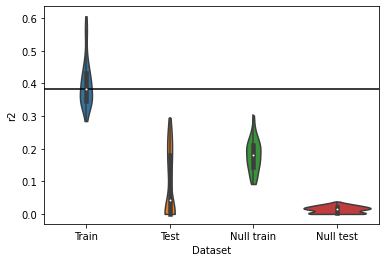

In [22]:
sns.violinplot(
    data=pd.DataFrame({
        "Train": train_r2,
        "Test": test_r2,
        "Null train": null_train_r2.mean(0),
        "Null test": null_test_r2.mean(0)
    }).melt(value_name="r2", var_name="Dataset"), 
    x="Dataset", 
    y="r2",
    cut=0
)
plt.axhline(full_r2, c="k")

In [16]:
parc = load_img(juspyce_vol.parc)
parc_data = parc.get_fdata()
parc_affine = parc.affine
parcels = np.trim_zeros(np.unique(parc_data))
n_parcels = len(parcels)
mask = np.logical_not(np.logical_or(np.isclose(parc_data, 0), np.isnan(parc_data)))
parc_data_m = parc_data * mask

# get centroid coordinates in world space
xyz = np.zeros((n_parcels, 3), float)
for i, i_parcel in enumerate(parcels):
    xyz[i,:] = np.column_stack(np.where(parc_data_m==i_parcel)).mean(axis=0)
ijk = nib.affines.apply_affine(parc_affine, xyz)

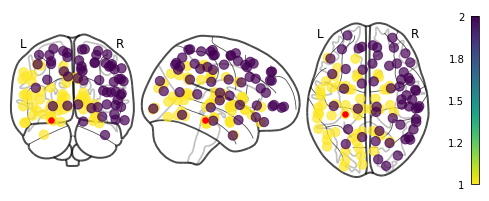

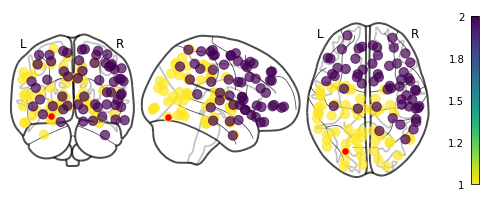

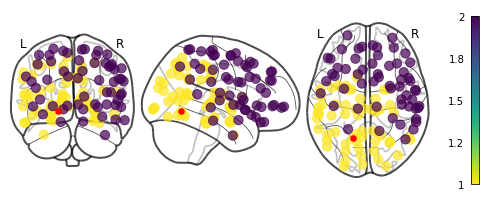

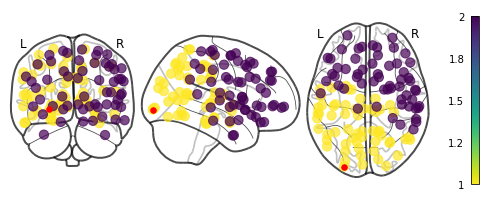

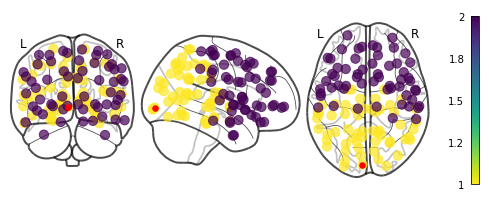

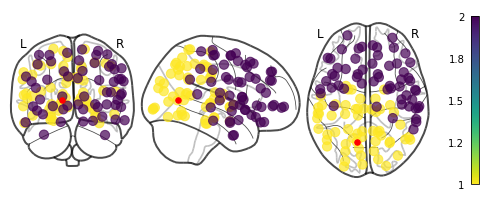

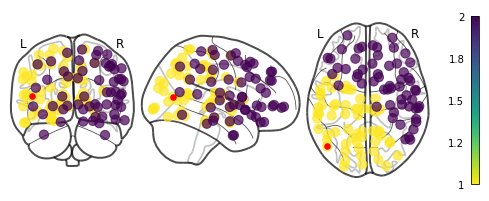

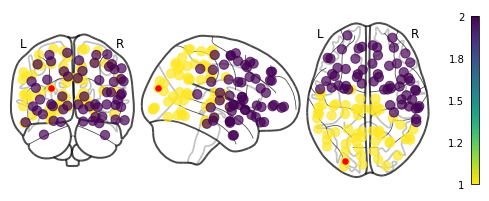

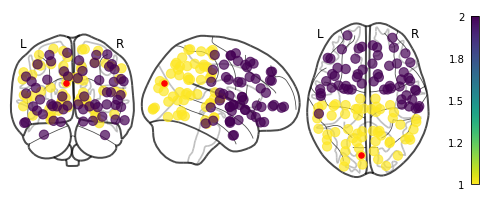

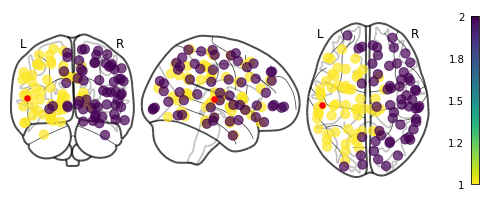

In [38]:
from nilearn.plotting import plot_markers

for i in range(10):

    distances = dist_mat[i, :]  # for every node
    idx = np.argsort(distances)
    train_idx = idx[:int(np.floor(0.5 * len(dist_mat)))]
    test_idx = idx[int(np.floor(0.5 * len(dist_mat))):]

    p = plot_markers([1]*len(train_idx) + [2]*len(test_idx), node_coords=np.r_[ijk[train_idx,:], ijk[test_idx,:]])
    p.add_markers(marker_coords=ijk[i:i+1,:])
    plt.show()